# How to deconvolve calcium imaging data without ground truth.
This demo shows how to predict spiking probabilities your calcium imaging data for which no ground truth is available. Two approaches are presented.

I. Based on a simple, pretrained convolutional network.

II. Based on the same network, but using a projection of the dataset to be analyzed into an embedding space in order to retrain the network on a focused subset of the ground truth.

- The demo is using a small dataset of 110 neurons, recorded simultaneously in a single FOV (experiment performed by Peter Rupprecht).
- Recording rate: 28 Hz (resonant scanning).
- Brain area: area Dp (piriform cortex homolog) and area Dl (hippocampal homolog) in adult zebrafish (brain explant, room temperature).
- Calcium indicator: GCaMP6f, expressed using a NeuroD promotor fragment (https://www.osapublishing.org/boe/abstract.cfm?uri=boe-7-5-1656 for details).
- Recording duration: ca. 3 minutes.
- Only spontaneous activity.

Authors: Peter Rupprecht, peter.rupprecht@fmi.ch; Stephan Gerhard, stephan.gerhard@fmi.ch

### Import dependencies
Apart from standard dependencies (scipy, matplotlib, numpy, copy and sklearn), a set of specialized functions is loaded that are part of this repository.

In [2]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from copy import deepcopy
import matplotlib.pyplot as plt
from elephant.utils2 import extract_stats, genhurst, map_between_spaces
from elephant.utils import norm
from elephant.c2s_preprocessing import preprocess, percentile_filter

### Load data
Load your calcium imaging data (modify according to your needs).

- load dataset as a simple 2D matrix (trace), here from a mat file
- framerate fs used for ca imaging

In [3]:
trace = sio.loadmat('demo_dataset/Adult_zebrafish_110neurons.mat')['FFF']
fs = 28

### Preprocess calcium time series
Preprocess data (upsample to 100 Hz, normalize offset/amplitude).<br />
The preprocessing is based on [Theis et al., 2016](http://dx.doi.org/10.1016/j.neuron.2016.04.014).

In [4]:
tracex, fsx = preprocess(trace,fs)

# Part I. The simple, pretrained CNN model

### Load CNN model

In [5]:
exec(open("elephant/config_elephant.py").read())
exec(open("elephant/2_model.py").read())

Using TensorFlow backend.


setup training data with 10 datasets


### Load model weights

In [6]:
model.load_weights("models/model1.h5")

### Make predictions

In [7]:
Ypredict = np.zeros((tracex.shape[0]-windowsize,tracex.shape[1]))
for k in range(0,trace.shape[1]):
    if np.mod(k,20) ==0:
        print('Predicting spikes for neuron %s out of %s' % (k+1, trace.shape[1]))
    x1x = tracex[:,k]
    idx = ~np.isnan(x1x)
    calcium_traceX = norm(x1x[idx])
    # initialize the prediction vector
    XX = np.zeros( (calcium_traceX.shape[0]-windowsize,windowsize,1),dtype = np.float32)
    for jj in range(0,(calcium_traceX.shape[0]-windowsize)):
        XX[jj,:,0] = calcium_traceX[jj:(jj+windowsize)]
    A = model.predict( XX,batch_size = 4096 )
    Ypredict[idx[0:len(idx)-windowsize],k] = A[:,0]

Predicting spikes for neuron 1 out of 110
Predicting spikes for neuron 21 out of 110
Predicting spikes for neuron 41 out of 110
Predicting spikes for neuron 61 out of 110
Predicting spikes for neuron 81 out of 110
Predicting spikes for neuron 101 out of 110


### Plot results
Plot calcium data as a 2D matrix. Y-axis corresponds to the 110 neurons, X-axis to time (total ca. 180 sec). <br />
It is necessary to discard the first and last few data points from the calcium traces, since the model cannot make predictions for them.

(-0.5, 17728.5, 109.5, -0.5)

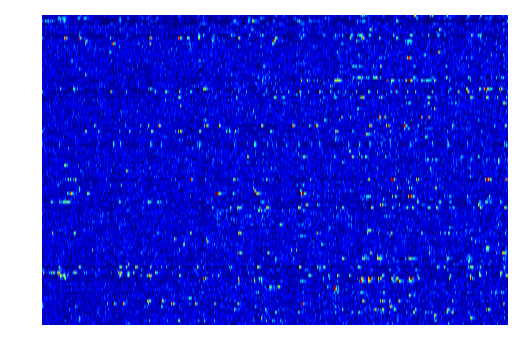

In [9]:
%matplotlib inline
plt.figure(102)
indizes = range(int(windowsize*before_frac),calcium_traceX.shape[0]-int(windowsize*after_frac))
plt.imshow(np.transpose(tracex[indizes,:]), aspect='auto')
plt.jet()
plt.clim(0,8)
plt.axis('off')

Plot deconvolved calcium data as a 2D matrix. Y-axis corresponds to the 110 neurons, X-axis to time (total ca. 180 sec).

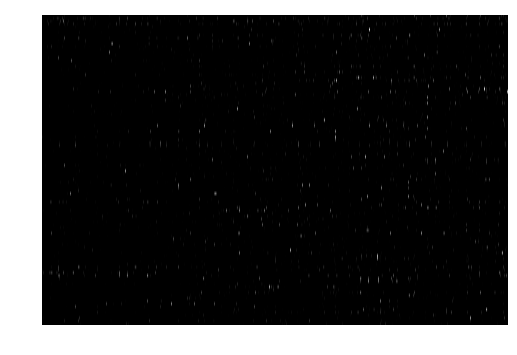

In [10]:
plt.figure(101)
plt.imshow(np.transpose(Ypredict), aspect='auto')
plt.gray()
plt.axis('off')
plt.clim(0.2,20)

Plot a single neuronal calcium trace, together with the predictions.

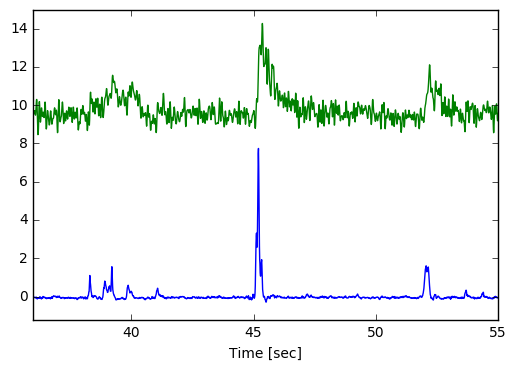

In [16]:
plt.figure(103)
neuron_index = 103
timet = np.arange(0,Ypredict.shape[0])/100
plt.plot(timet,Ypredict[:,neuron_index]*0.5)
plt.plot(timet,tracex[indizes,neuron_index]+9)
plt.xlim(36,55)
plt.ylim(-1.2, 15)
plt.xlabel('Time [sec]')

This result is generated using the basic pre-trained model. Part II will retrain this model in order to be better adapted to the particularities of the dataset that is analyzed.

# PART II. The embedded model with focused re-training.

### Compute statistical properties of your dataset
Computes statistical properties like skewness, autocorrelation, power spectral densities or Hurst coefficients, which are used to map the dataset into the embedding space created by the ground truth dataset, in order to choose the ground truth data best-suited for re-training of the model.

In [ ]:
stats = extract_stats(tracex[:,:])

### Compute location in embedding space
First, the statistical parameters of the ground truth datasets (Parameters174, based on 174 neurons) are loaded. <br />
This parameter space is then projected into a 2D embedding space (`pca2`). <br />
This transformation is then used to project the statistics computed above `stats` into this embedding space. <br />
This yields a single 2D point, the location of the dataset to be analyzed in the embedding space.

In [ ]:
A = sio.loadmat('statEmbedding/Parameters174py.mat',variable_names=['DasetS','Parameters174','Parameters174temp'])
DasetS = A['DasetS']
Parameters174temp = A['Parameters174temp']
Parameters174 = A['Parameters174']
goodindizes = sio.loadmat('statEmbedding/embedding_spacesX.mat')['goodindizes']

Parameters174 = Parameters174[:,goodindizes]
DasetS = DasetS[goodindizes]

ParametersXX = np.squeeze(deepcopy(Parameters174))
for k in range(0,10):
    indizes = np.where(DasetS==k+1)[0]
    for j in range(0,18):
        ParametersXX[j,indizes] = np.mean(ParametersXX[j,indizes])

pca2 = PCA(n_components=2)
pca2.fit(np.transpose(ParametersXX))

for k in range(0,18):
    stats[:,k] = (stats[:,k] - np.mean(Parameters174temp[:,k]))/np.std(Parameters174temp[:,k])
P1 = pca2.transform(stats)
P1mean = np.mean(P1,axis=0)

### Compute location in predictive embedding space
Transforms the location in the statistical embedding space into a location of the embedding space of mututal predictivity.

In [ ]:
distances = map_between_spaces(P1mean)

### Retrain model in a local environment
First load ground truth data, used for retraining of the model. <br />
Since the datasets of the ground truth or not equally large, it is necessary to use them accordingly for retraining in a weighted manner. To this end, the number of samples of the datasets have to be known.

In [ ]:
exec(open("elephant/1_load_data.py").read())
dataset_sizes = np.array((740777, 672625, 563966, 165048, 149976, 171687, 875247, 486090, 584103, 697437),dtype=float)
dataset_fraction_to_take = np.min(dataset_sizes)/dataset_sizes

### Importance of dataset decays with distance in embedding space

In [ ]:
distancesX = np.exp(-(distances)/3.5)
distancesX = distancesX/np.max(distancesX)

### Train for 5 epochs with changing datasubsets
Retrains the model with subsets of the ground truth dataset. <br />
The subset is selected based on the distance of the respective recordings to the computed location in the predictive embedding space (`distancesX`).

In [ ]:
for jjj in range(0,5):
    XX0 = np.empty((0,128,1))
    YY0 = np.empty((0,1))
    for kk in range(0,10):
        dataset_chosen = kk + 1
        datasets_to_train = {}
        IY = datasets == dataset_chosen
        datasets_to_train[dataset_chosen] = neurons[IY]
        verbosity = 0
        exec( open("elephant/3_preprocessing.py").read() )
        X = X[0:int(X.shape[0]*distancesX[kk]*dataset_fraction_to_take[kk]),:,:]
        Y = Y[0:int(Y.shape[0]*distancesX[kk]*dataset_fraction_to_take[kk]),:]
        XX0 = np.concatenate((XX0,X),axis=0)
        YY0 = np.concatenate((YY0,Y),axis=0)
        
    learning_rate = 0.0033
    model.optimizer.lr.assign(learning_rate)
    model.fit(XX0, YY0, batch_size=batch_size, epochs=1)

### Make predictions based on the refined model

In [ ]:
Ypredict = np.zeros((tracex.shape[0]-windowsize,tracex.shape[1]))
for k in range(0,trace.shape[1]):
    print('Predicting spikes for neuron %s out of %s' % (k+1, trace.shape[1]))
    x1x = tracex[:,k]
    idx = ~np.isnan(x1x)
    calcium_traceX = norm(x1x[idx])
    # initialize the prediction vector
    XX = np.zeros( (calcium_traceX.shape[0]-windowsize,windowsize,1),dtype = np.float32)
    for jj in range(0,(calcium_traceX.shape[0]-windowsize)):
        XX[jj,:,0] = calcium_traceX[jj:(jj+windowsize)]
    A = model.predict( XX,batch_size = 4096 )
    Ypredict[idx[0:len(idx)-windowsize],k] = A[:,0]

### Plot refined results

In [ ]:
plt.figure(103)
plt.imshow(np.transpose(Ypredict), aspect='auto')
plt.gray()
plt.clim(0.2,20)
plt.figure(104)
plt.imshow(np.transpose(tracex[int(windowsize*before_frac):calcium_traceX.shape[0]-int(windowsize*after_frac),:]), aspect='auto')
plt.jet()
plt.clim(0,8)